In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import Necessary Libraries

In [ ]:
!pip install -q evaluate transformers datasets mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 10.4 MB/s eta 0:00:00
     ━━━━━━

In [ ]:
!pip install tensorflow

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import tensorflow as tf
from transformers import ViTFeatureExtractor, TFAutoModelForImageClassification
from sklearn.model_selection import train_test_split


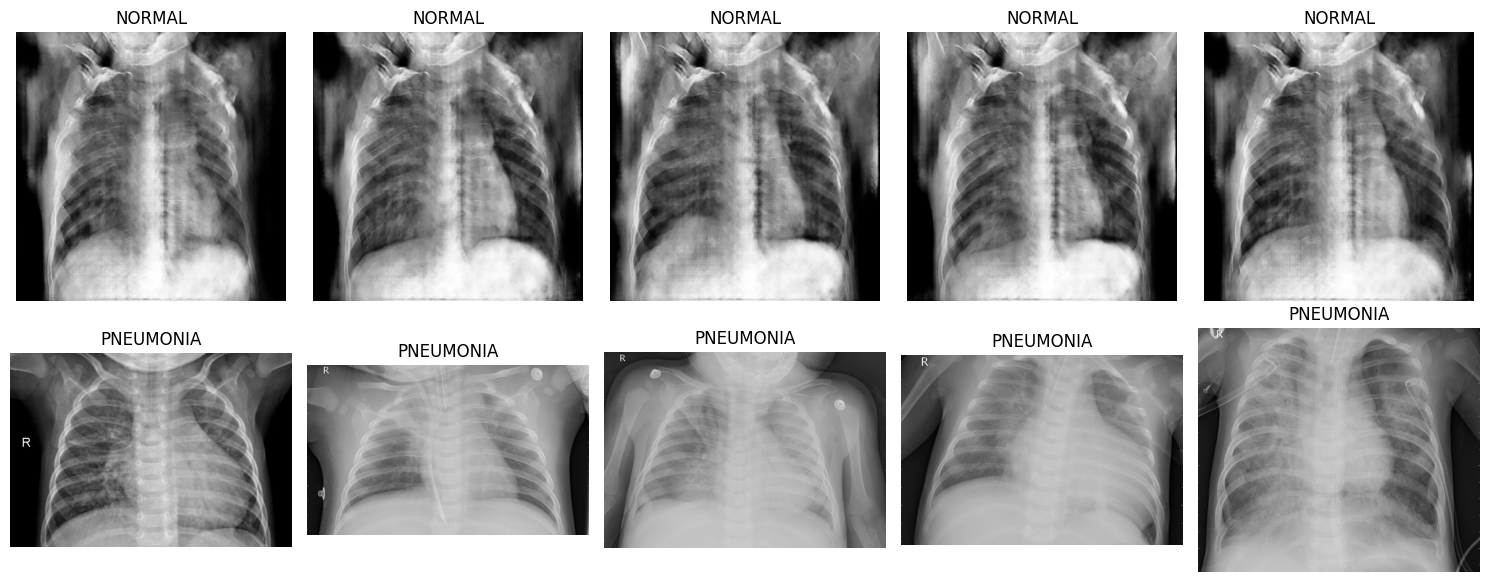

In [ ]:
# Directory paths
train_dir = Path("/content/drive/MyDrive/chest_xray/train")
val_dir = Path("/content/drive/MyDrive/chest_xray/val")
test_dir = Path("/content/drive/MyDrive/chest_xray/test")

# Displaying a few images
def display_images(folder, num=5):
    pneumonia_imgs = list(folder.glob('PNEUMONIA/*.jpeg'))[:num]
    normal_imgs = list(folder.glob('NORMAL/*.jpeg'))[:num]

    fig, axes = plt.subplots(nrows=2, ncols=num, figsize=(15, 6))

    for i, img_path in enumerate(normal_imgs):
        img = Image.open(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title("NORMAL")
        axes[0, i].axis('off')

    for i, img_path in enumerate(pneumonia_imgs):
        img = Image.open(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title("PNEUMONIA")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

display_images(train_dir)


## Data Preprocessing

We'll define transformations for the images to make them suitable for input into the ViT model.


In [ ]:
from torchvision import transforms

# Define transformations for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
label_mapping = {"NORMAL": 0, "PNEUMONIA": 1}

## Creating Data Loaders

Data loaders provide an efficient way to iterate through the dataset in batches.


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Creating datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(test_dir, transform=val_test_transforms)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Setting Up the Vision Transformer (ViT) Model

We'll be using the ViT model pre-trained on a large dataset and fine-tuning it on our chest X-ray dataset.


In [ ]:
from transformers import ViTForImageClassification, ViTConfig, ViTImageProcessor

# Define the ViT configuration
config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
config.num_labels = 2  # Normal and Pneumonia

# Load the pre-trained model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", config=config)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define Loss and Optimizer

We'll use the CrossEntropy loss as it's suitable for binary classification tasks. For optimization, we'll use the Adam optimizer.


In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)


## Model Training

Let's train the ViT model on our chest X-ray dataset. We'll also validate the model on the validation set after each epoch.


In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm

# Check for GPU availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the training function with checkpoints
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, checkpoint_path='/content/drive/MyDrive/chest_xray/checkpoints/checkpoint.pth'):
    train_losses = []  # List to store training loss for each epoch
    val_accuracies = []  # List to store validation accuracy for each epoch

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images).logits  # Get logits from model outputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            progress_bar.set_postfix({'loss': loss.item()})

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader.dataset)
        val_accuracy = 100 * correct / total

        # Append the computed values to their respective lists
        train_losses.append(avg_train_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Save the model checkpoint after each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_accuracy': val_accuracy
        }, checkpoint_path)

    return model, train_losses, val_accuracies


In [ ]:
model, train_losses, val_accuracies = train_model(model=model, criterion=criterion, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader, num_epochs=2)

Epoch 1/2, Loss: 0.1748, Validation Accuracy: 94.95%


Epoch 2/2, Loss: 0.0582, Validation Accuracy: 96.97%


## Training and Validation Metrics Visualization

Plotting the training loss and validation accuracy to understand the model's learning progress.


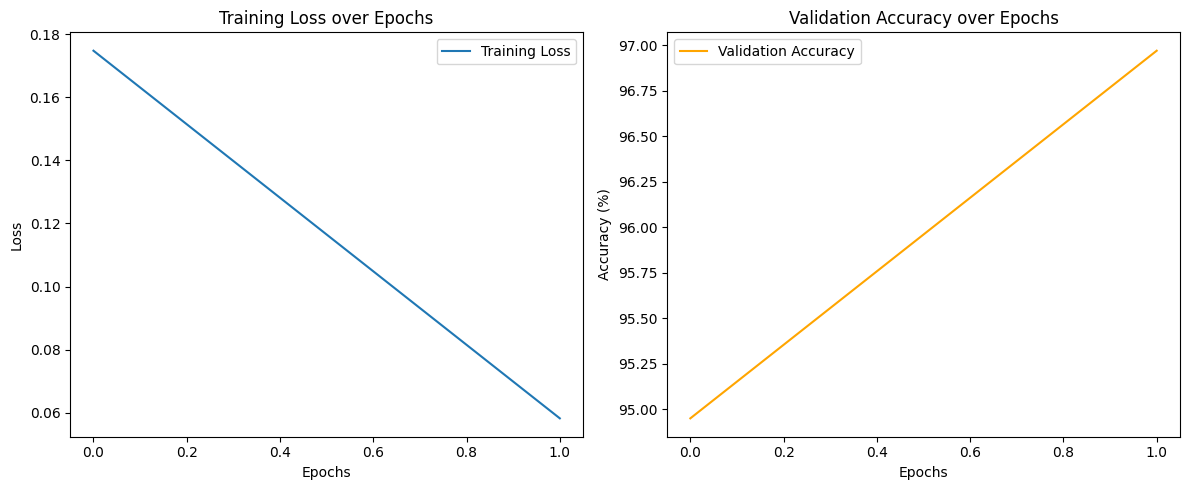

In [ ]:
plt.figure(figsize=(12, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


## Save and Load the Model

After training, it's essential to save the model weights to avoid retraining in the future.


In [ ]:
# Save the model weights
torch.save(model.state_dict(), "/content/drive/MyDrive/chest_xray/models/vit_chest_xray_model_5epochs.pth")

# to load the model in the future
#model.load_state_dict(torch.load("/content/drive/MyDrive/chest_xray/models/vit_chest_xray_model.pth", map_location=torch.device('cpu')))


## Metrics

Visualizing the model's predictions using a confusion matrix to understand its performance in more detail.


Accuracy Score: 0.8483412322274881
Precision Score: 0.8037190082644629
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.61      0.76       243
           1       0.80      1.00      0.89       390

    accuracy                           0.85       633
   macro avg       0.90      0.80      0.82       633
weighted avg       0.88      0.85      0.84       633



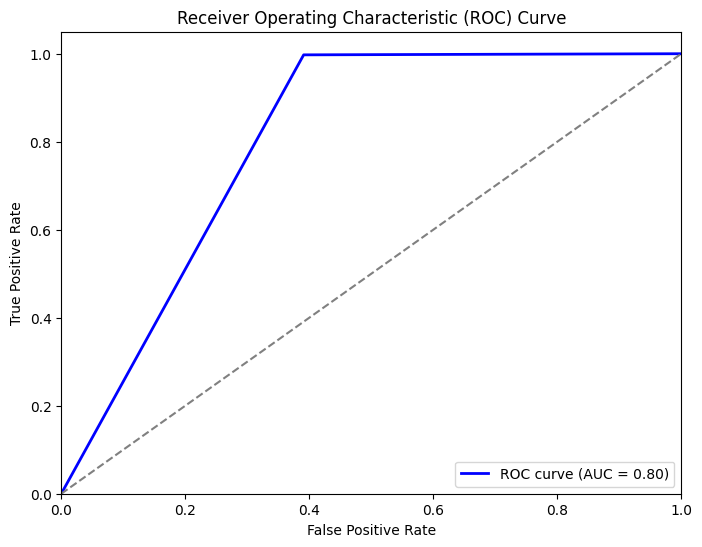

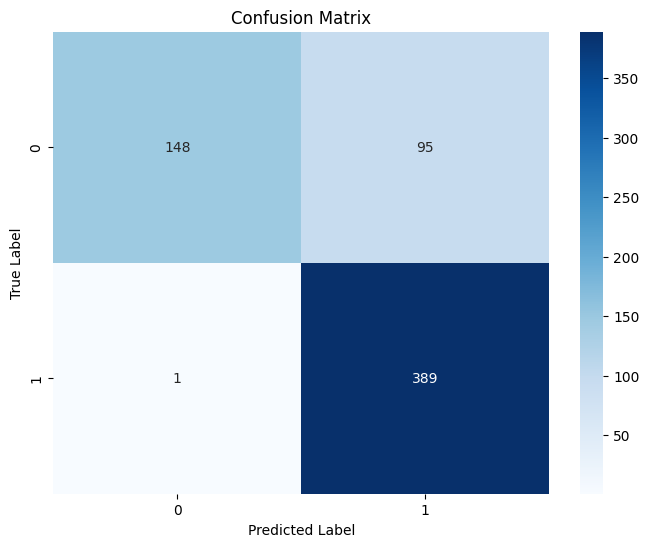

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming test_loader is your test data loader and model is your trained model

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = outputs.max(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
    class_matrix = confusion_matrix(y_true, y_pred)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_true, y_pred)

    return accuracy, precision, class_report, class_matrix, fpr, tpr, roc_auc

# Evaluate the model
accuracy, precision, class_report, class_matrix, fpr, tpr, roc_auc = evaluate_model(model, test_loader)

# Print metrics
print(f'Accuracy Score: {accuracy}')
print(f'Precision Score: {precision}')
print(f'Classification Report:\n{class_report}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(class_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
